In [1]:
import functools
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

sns.set_context("talk")
mpl.rcParams['font.sans-serif'] = ["muli"]

%matplotlib inline

In [2]:
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pandas as pd
from openff.toolkit import Molecule, ForceField
import tqdm

In [3]:
def _get_column(dataset, column: str):
    return dataset.to_table(columns=[column]).to_pydict()[column]

In [4]:
dataset = ds.dataset("tables")
dataset.schema

type: string
qcarchive_id: int64
cmiles: string
inchi_key: string
smiles: string
dataset: string
specification: string
torsiondrive_id: int64
dihedral_indices: list<element: list<element: int64>>
  child 0, element: list<element: int64>
      child 0, element: int64
grid_ids: list<element: int64>
  child 0, element: int64
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 1462

In [5]:
dataset.count_rows()

931105

In [6]:
smiles = _get_column(dataset, "smiles")[0]

In [78]:
smiles

'[NH3+]C12CC3CC(CC(C3)C1)C2'

In [80]:
df2 = dataset.filter(pc.field("smiles") == smiles).to_table().to_pandas()
df2

,type,qcarchive_id,cmiles,inchi_key,smiles,dataset,specification,torsiondrive_id,dihedral_indices,grid_ids
0,optimization,6092820,[H:12][C:1]1([C:7]2([C:2]([C:9]3([C:3]([C:8]1(...,DKNWSYNQZKUICI-IFTCQQCTNA-O,[NH3+]C12CC3CC(CC(C3)C1)C2,FDA Optimization Dataset 1,default,-1,"[[-1, -1, -1, -1]]",[-1]
1,optimization,6092820,[H:12][C:1]1([C:7]2([C:2]([C:9]3([C:3]([C:8]1(...,DKNWSYNQZKUICI-IFTCQQCTNA-O,[NH3+]C12CC3CC(CC(C3)C1)C2,OpenFF Full Optimization Benchmark 1,default,-1,"[[-1, -1, -1, -1]]",[-1]


In [7]:
inchis = set(_get_column(dataset, "inchi_key"))
print(len(inchis))

66391


In [47]:
@functools.cache
def _profile(smi: str) -> int:
    mol = Molecule.from_smiles(smi, allow_undefined_stereo=True)
    n_atoms = mol.n_atoms
    total_charge = sum([atom.formal_charge for atom in mol.atoms]).m
    n_heavy_atoms = sum(1 for atom in mol.atoms if atom.atomic_number != 1)
    total_weight = sum(atom.mass for atom in mol.atoms).m
    return {"n_atoms": n_atoms, "total_charge": total_charge, "n_heavy_atoms": n_heavy_atoms, "mw": total_weight}

In [48]:
entries = [
    _profile(x) for x in tqdm.tqdm(_get_column(dataset, "smiles"))
]

100%|████████████████████████████████| 931105/931105 [01:26<00:00, 10716.41it/s]


In [49]:
df = pd.DataFrame(entries)

In [50]:
n_qcarchive_id = len(set(_get_column(dataset, "qcarchive_id")))

In [51]:
n_qcarchive_id

764675

In [52]:
df

,n_atoms,total_charge,n_heavy_atoms,mw
0,29,1,11,152.257566
1,23,0,17,295.725222
2,25,0,17,297.741116
3,23,0,17,295.725222
4,25,0,17,297.741116
...,...,...,...,...
931100,13,0,6,90.096582
931101,13,0,6,90.096582
931102,13,0,6,90.096582
931103,13,0,6,90.096582


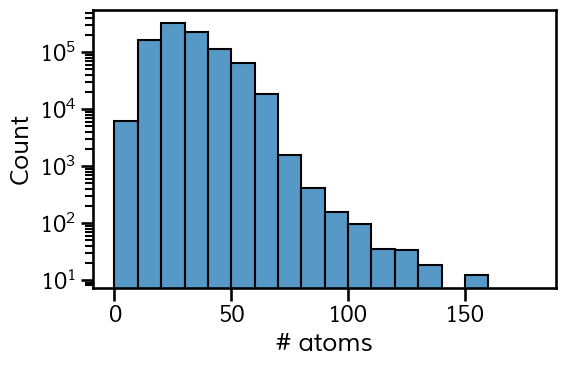

In [53]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(
    ax=ax,
    data=df.n_atoms,
    binrange=(0, 180),
    binwidth=10,
)
ax.set_xlabel("# atoms")
plt.yscale("log")
plt.tight_layout()
plt.savefig("images/n_atoms.png", dpi=300)

In [54]:
df.n_heavy_atoms.max()

82

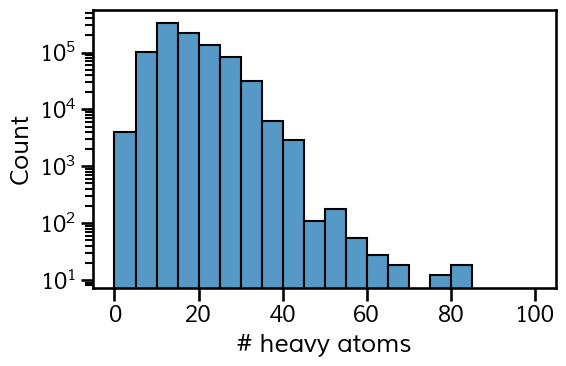

In [55]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(
    ax=ax,
    data=df.n_heavy_atoms,
    binrange=(0, 100),
    binwidth=5,
)
ax.set_xlabel("# heavy atoms")
plt.yscale("log")
plt.tight_layout()
plt.savefig("images/n_heavy_atoms.png", dpi=300)

In [56]:
df.total_charge.max()

3

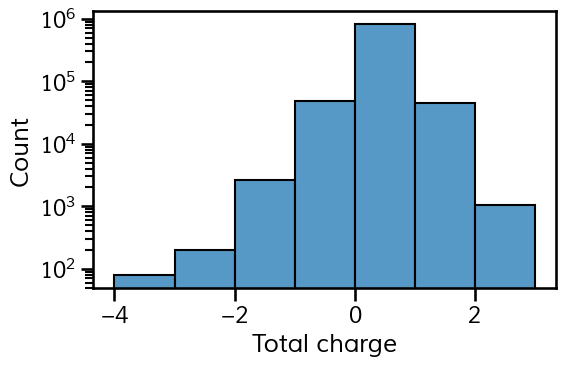

In [46]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(
    ax=ax,
    data=df.total_charge,
    binrange=(-4, 3),
    binwidth=1,
)
ax.set_xlabel("Total charge")
plt.yscale("log")
plt.tight_layout()
plt.savefig("images/total_charge.png", dpi=300)

In [65]:
df.mw.max()

1105.1603120000018

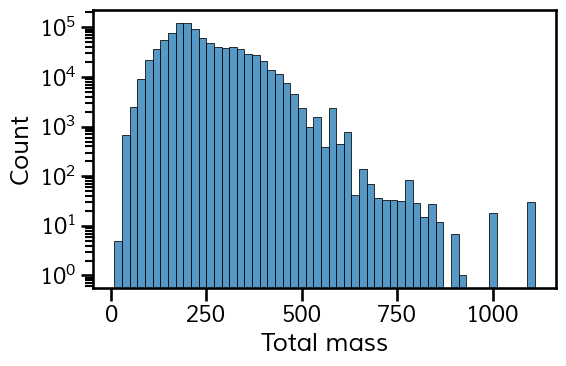

In [69]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(
    ax=ax,
    data=df.mw,
    binrange=(10, 1110),
    binwidth=20,
)
ax.set_xlabel("Total mass")
plt.yscale("log")
plt.tight_layout()
plt.savefig("images/mw.png", dpi=300)

In [64]:
round(178, -1)

180

In [62]:
help(round)

Help on built-in function round in module builtins:

round(number, ndigits=None)
    Round a number to a given precision in decimal digits.
    
    The return value is an integer if ndigits is omitted or None.  Otherwise
    the return value has the same type as the number.  ndigits may be negative.



In [24]:
dataset = ds.dataset("labels/checkmol/")
dataset.schema

1,2 Aminoalcohol: bool
1,2 Diol: bool
1,2 Diphenol: bool
Acetal: bool
Acyl Bromide: bool
Acyl Chloride: bool
Acyl Cyanide: bool
Acyl Fluoride: bool
Acyl Halide: bool
Acyl Iodide: bool
Alcohol: bool
Aldehyde: bool
Alkane: bool
Alkene: bool
Alkyl Bromide: bool
Alkyl Chloride: bool
Alkyl Fluoride: bool
Alkyl Halide: bool
Alkyl Iodide: bool
Alkylarylether: bool
Alkylthiol: bool
Alkyne: bool
Alpha Aminoacid: bool
Alpha Hydroxyacid: bool
Aminal: bool
Amine: bool
Anion: bool
Aqueous: bool
Aromatic: bool
Aryl Bromide: bool
Aryl Chloride: bool
Aryl Fluoride: bool
Aryl Halide: bool
Aryl Iodide: bool
Arylthiol: bool
Azide: bool
Azo Compound: bool
Boronic Acid: bool
Boronic Acid Derivative: bool
Boronic Acid Ester: bool
CO2 Derivative: bool
Carbamic Acid: bool
Carbamic Acid Derivative: bool
Carbamic Acid Ester: bool
Carbamic Acid Halide: bool
Carbodiimide: bool
Carbonic Acid Derivative: bool
Carbonic Acid Diester: bool
Carbonic Acid Ester Halide: bool
Carbonic Acid Monoester: bool
Carbonyl: bool
C

In [25]:
dataset.count_rows()

65923

In [26]:
df = dataset.to_table().to_pandas()

In [27]:
columns = df.columns[:-2] # last is smiles and InChI
counts = df[columns].sum()

In [28]:
counts.sort_values()

Ketene                            0
Organolithium                     0
Organomagnesium                   0
Organometallic                    0
Phosphoric Acid                   0
                              ...  
Ether                         11119
Carboxylic Acid Derivative    15521
Oxohetarene                   21083
Aromatic                      45590
Heterocycle                   55032
Length: 206, dtype: int64

In [154]:
counts.sort_values(ascending=False).to_csv("counts.csv")

In [142]:
for x in columns:
    print(x)

1,2 Aminoalcohol
1,2 Diol
1,2 Diphenol
Acetal
Acyl Bromide
Acyl Chloride
Acyl Cyanide
Acyl Fluoride
Acyl Halide
Acyl Iodide
Alcohol
Aldehyde
Alkane
Alkene
Alkyl Bromide
Alkyl Chloride
Alkyl Fluoride
Alkyl Halide
Alkyl Iodide
Alkylarylether
Alkylthiol
Alkyne
Alpha Aminoacid
Alpha Hydroxyacid
Aminal
Amine
Anion
Aqueous
Aromatic
Aryl Bromide
Aryl Chloride
Aryl Fluoride
Aryl Halide
Aryl Iodide
Arylthiol
Azide
Azo Compound
Boronic Acid
Boronic Acid Derivative
Boronic Acid Ester
CO2 Derivative
Carbamic Acid
Carbamic Acid Derivative
Carbamic Acid Ester
Carbamic Acid Halide
Carbodiimide
Carbonic Acid Derivative
Carbonic Acid Diester
Carbonic Acid Ester Halide
Carbonic Acid Monoester
Carbonyl
Carbonyl Hydrate
Carboxylic Acid
Carboxylic Acid Amide
Carboxylic Acid Amide Acetal
Carboxylic Acid Amidine
Carboxylic Acid Amidrazone
Carboxylic Acid Anhydride
Carboxylic Acid Azide
Carboxylic Acid Derivative
Carboxylic Acid Ester
Carboxylic Acid Hydrazide
Carboxylic Acid Imide
Carboxylic Acid Orthoester


In [30]:
import re

In [31]:
counts[[bool(re.search("[Aa]z", x)) for x in counts.index]]

Azide                           56
Azo Compound                   424
Carboxylic Acid Amidrazone      34
Carboxylic Acid Azide            1
Carboxylic Acid Hydrazide     1038
Diazonium Salt                   8
Hydrazine                     1916
Hydrazone                      528
Semicarbazide                   27
Semicarbazone                   25
Thiosemicarbazide                6
Thiosemicarbazone                9
dtype: int64

In [32]:
counts[["Alkane"]]

Alkane    287
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '1,2 Aminoalcohol'),
  Text(1, 0, '1,2 Diol'),
  Text(2, 0, '1,2 Diphenol'),
  Text(3, 0, 'Alcohol'),
  Text(4, 0, 'Enediol'),
  Text(5, 0, 'Enol'),
  Text(6, 0, 'Enolether'),
  Text(7, 0, 'Organolithium'),
  Text(8, 0, 'Phenol'),
  Text(9, 0, 'Primary Alcohol'),
  Text(10, 0, 'Secondary Alcohol'),
  Text(11, 0, 'Tertiary Alcohol')])

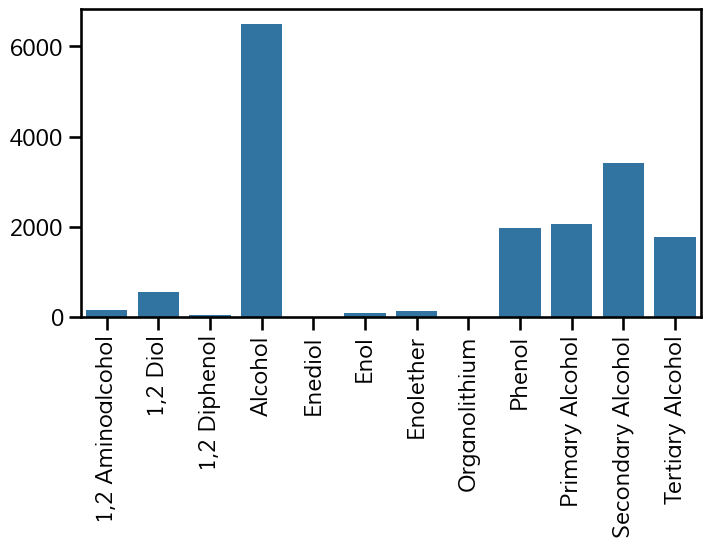

In [103]:
fig, ax = plt.subplots(figsize=(8, 4))

ax = sns.barplot(
    ax=ax,
    data=counts[[("ol" in x) and ("hiol" not in x) and ("organoli" not in x) for x in counts.index]],
)
plt.xticks(rotation=90)

In [160]:
counts[(counts > 0) & (counts <=5)]

Acyl Cyanide                  2
Aqueous                       1
CO2 Derivative                5
Carbamic Acid Halide          1
Carbodiimide                  1
Carbonic Acid Ester Halide    1
Carbonic Acid Monoester       3
Carboxylic Acid Azide         1
Carboxylic Acid Orthoester    3
Cyanate                       1
Enediol                       1
Nitrite                       1
Phosphoric Acid Halide        2
Sulfenic Acid                 2
Sulfenic Acid Ester           1
Sulfinic Acid Ester           3
Sulfinic Acid Halide          2
Sulfuric Acid                 5
Sulfuric Acid Diester         4
Tertiary Aromatic Amine       5
Thioketone                    5
dtype: int64

In [ ]:
counts

In [19]:
dataset.filter(pc.field("Hydrazine")).to_table(columns=["smiles", "inchi"]).to_pandas().smiles.values

array(['NNc1nncc2ccccc12', 'N/N=c1\\[nH]ncc2ccccc12',
       'NNc1[nH+]ncc2ccccc12', ..., 'CN/N=C(\\O)N(C)C', 'CN/N=C(/O)N(C)C',
       'N#CS(=O)(=O)c1ccc(NN)cc1'], dtype=object)

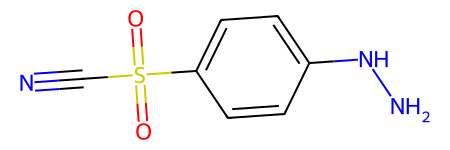

In [20]:
from rdkit import Chem

Chem.MolFromSmiles("N#CS(=O)(=O)c1ccc(NN)cc1")

In [22]:
dataset = ds.dataset("labels/forcefield-parameters/openff-2.2.0")

In [28]:
df = dataset.to_table().to_pandas()
columns = df.columns[:-4]
counts = df[columns].sum()

In [29]:
df.columns

Index(['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10',
       ...
       'n33', 'n34', 'n35', 'n-tip3p-O', 'n-tip3p-H', 'n36', 'c1', 'smiles',
       'inchi', 'forcefield'],
      dtype='object', length=363)

In [31]:
subcounts = counts[[x.startswith("b") for x in counts.index]]

In [32]:
subcounts[0:100]

b1     29459
b2     17919
b3      7734
b4     35448
b5     24744
       ...  
b84    36879
b85    49876
b86      191
b87    32056
b88    13524
Length: 90, dtype: int64

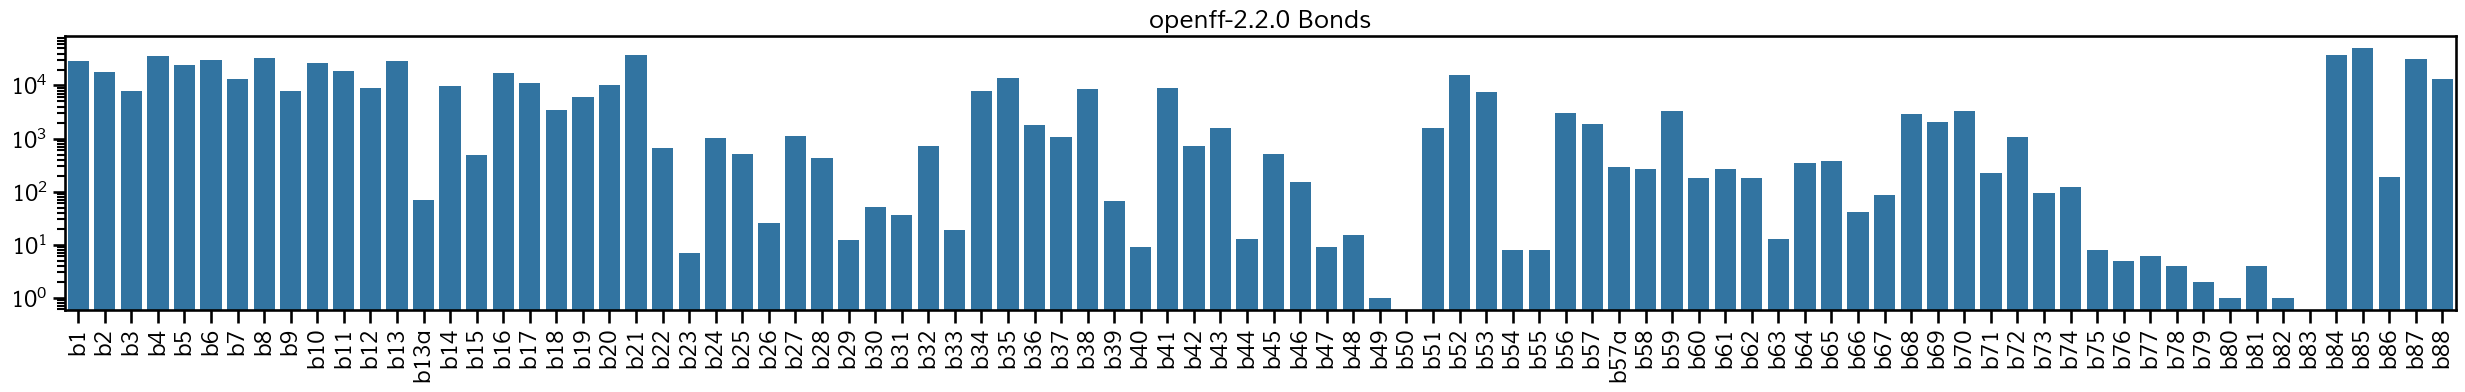

In [25]:
fig, ax = plt.subplots(figsize=(25, 4))

ax = sns.barplot(
    ax=ax,
    data=counts[[x.startswith("b") for x in counts.index]]
)
plt.yscale("log")
plt.xticks(rotation=90);
plt.tight_layout()
ax.set_title("openff-2.2.0 Bonds")
plt.savefig("images/openff-2.2.0_Bonds_total.png", dpi=300)

In [3]:
ff = ForceField("openff-2.2.0.offxml")
bond_handler = ff.get_parameter_handler("Bonds")

In [55]:
bond_handler.get_parameter({"id": "b55"})

[<BondType with smirks: [#16X2:1]=[#8X1,#7X2:2]  id: b55  length: 1.5213240050039034 angstrom  k: 992.5556417122765 kilocalorie_per_mole / angstrom ** 2  >]

In [56]:
angle_handler = ff.get_parameter_handler("Angles")

In [57]:
len(angle_handler.parameters)

44

In [62]:
angle_handler.get_parameter({"id": "a30"})

[<AngleType with smirks: [*:1]-[#8X2+1:2]=[*:3]  angle: 122.99227453817346 degree  k: 323.7005670962272 kilocalorie_per_mole / radian ** 2  id: a30  >]

In [4]:
torsion_handler = ff.get_parameter_handler("ProperTorsions")

In [21]:
torsion_handler.get_parameter({"id": "t57"})

[<ProperTorsionType with smirks: [#1:1]-[#6X4:2]-[#7X3$(*@1-[*]=,:[*][*]=,:[*]@1):3]-[*:4]  periodicity1: 2  phase1: 180.0 degree  id: t57  k1: 0.840277035679 kilocalorie / mole  idivf1: 1.0  >]